# NN-Subsampling Algorithm

The sampling algorithm is an iterative process based on Nearest Neighbour search. 

In each iteration, the dataset is normalized with the standard scaler (mean = 0, standard deviation = 1) and a nearest-neighbour model is constructed and queried to find the nearest neighbor for each data point as well as the distance between them. If the distance is below a certain cutoff distance, the neighbor is removed with some probability. The process is iterated until there are no more points to be removed. 

The algorithm has two hyper-parameters: cutoff distance and deletion probability. 

The cutoff distance controls the sparsity of the resulting representative dataset. Higher cutoff distances resulting in fewer sub-sampled points.
The deletion probability controls robustness. Lower deletion probablibity is more robust but resulting in slower execution.

High-dimensional datasets are also pre-processed by principal component analysis (PCA) to reduce the dimensionality  prior to subsampling


The illustration of the subsampling procedure is shown in the Figure below

<center>
    <img src="./subsample_schema.JPG" width = 500>
</center>

The Nearest-Neighbour search on the backend can use any one of the models below:

* FLANN: http://www.cs.ubc.ca/research/flann/

* pykdtree: https://github.com/storpipfugl/pykdtree

* Annoy: https://github.com/spotify/annoy

* nmslib: https://github.com/nmslib/nmslib/tree/master/python_bindings

* scipy cKDTree

* scikit-learn nearest neighbor

Please make sure you have at least one of these packages installed before trying the algorithm (also remember to specify the method in your script)

Also note that different package varys (sometimes very significantly) in speed, efficiency and result

In [1]:
from __future__ import print_function
import numpy as np
from sklearn import preprocessing
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import random
try: import cPickle as pickle
except: import pickle
from math import ceil
from math import sqrt
try: from pyflann import *
except: pass
try: from pykdtree.kdtree import KDTree
except: pass
try: from sklearn.neighbors import NearestNeighbors
except: pass
try: from annoy import AnnoyIndex
except: pass
try: from scipy.spatial import cKDTree
except: pass
try: import nmslib
except: pass

## Helper Functions

In [2]:
def get_data_process(li, list_of_index):
    """
    Select features of a list based on index set
    """   
    result = []
    for entry in li:
        result.append([entry[i] for i in list_of_index])
    return result

def get_array_based_on_index(li, list_of_index):
    """
    Select entries from a list based on index set
    """
    return np.asarray([li[i] for i in list_of_index])

def remove_list_from_list(a,b):
    """
    Remove entries in list a that's also in list b
    """
    return list(set(a)-set(b))

def chunker(seq, size):
    """
    break a list (seq) into a set of equally sized (size) lists
    """
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))



## NN-Subsample Functions

In [3]:

def get_subsampling_index2(data_process, standard_scale = True, cutoff_sig = 0.02, rate = 0.3, \
                           method = "pykdtree", verbose = True):
    
    """
    Using Nearest-Neighbor search based algorithm, find the list of indices of the subsampled dataset
    
    
    Parameters
    -------------
    data_process: the list of datapoints, with selected features
    
    standard_scale: whether to apply standard scaler to the dataset prior to subsampling
    
    cutoff_sig: cutoff significance. the cutoff distance equals to the Euclidean 
                norm of the standard deviations in all dimensions of the data points 
    
    rate: possibility of deletion
    
    method: which backend nearest neighbour model to use.
    
    verbose: whether to output result of each iteration
    
    
    Return
    -------------
    overall_keep_list: The list of indices of the final subsampled entries
    
    """
    
    
    
    
    print("Started NN-subsampling, original length: {}".format(len(data_process)))
    
    method = method.lower()
    start = time.time()
    
    
    if method == "flann":
        print("use flann backend")
    elif method == "pykdtree":
        print("use pykdtree backend")
    elif method == "sklearn":
        print("use slearn nearest neighbors backend")
    elif method == "scipy":
        print("use scipy cKDTree backend")
    elif method == "annoy":
        print("use annoy backend")
    elif method == "nmslib":
        print("use nmslib backend")
    else:
        print("method {} not impletemented".format(method))
        raise NotImplemented
    
    # apply standard scaling 
    if standard_scale:
        if verbose:
            print("Subample with standard scaled data")
        data_process = StandardScaler().fit_transform(np.asarray(data_process).copy())
    else:
        if verbose:
            print("Subample with original data")
        data_process = np.asarray(data_process).copy()
    
    
    #set cutoff distance
    list_of_descs = zip(*data_process)
    sum_std2 = 0.    
    for descs in list_of_descs:
        temp_std = np.std(descs)
        sum_std2 += temp_std**2
    cutoff = cutoff_sig * np.sqrt(sum_std2)
    
    
    #initialize the index  
    overall_keep_list = np.arange(len(data_process)).tolist() 
    
    keep_going = True
    while keep_going:
        if verbose:
            print('start total length: {}'.format(len(overall_keep_list)))
        start_cycle = time.time()
        temp_data_process = get_array_based_on_index(data_process.copy(), overall_keep_list)
        
        
        #build and query nearest neighbour model
        if method == "flann":
            flann = FLANN()
            indices, distances = flann.nn(temp_data_process, temp_data_process, 2, algorithm="kmeans")
        elif method == "scipy":
            kd_tree = cKDTree(temp_data_process)
            distances, indices = kd_tree.query(temp_data_process, k=2)
        elif method == "pykdtree":
            kd_tree = KDTree(temp_data_process,leafsize=6)
            distances, indices = kd_tree.query(temp_data_process, k=2)
        elif method == "sklearn":
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='kd_tree',n_jobs=-1).fit(temp_data_process)
            distances, indices = nbrs.kneighbors(temp_data_process)
        elif method == "annoy":
            annoy = AnnoyIndex(len(temp_data_process[0]),metric='euclidean')
            for i in range(len(temp_data_process)):
                annoy.add_item(i,temp_data_process[i])
            annoy.build(1)
            distances = []
            indices = []
            for i in range(len(temp_data_process)):
                temp_index, temp_dist = annoy.get_nns_by_vector(temp_data_process[i], 2, include_distances=True)
                indices.append([i, temp_index[1]])
                distances.append([0.0, temp_dist[1]])
        elif method == "nmslib":
            index = nmslib.init(method='hnsw', space='l2')
            index.addDataPointBatch(temp_data_process)
            index.createIndex( print_progress=True)

            neighbours = index.knnQueryBatch(temp_data_process, k=2) 
            
            distances = []
            indices = []
            for item in neighbours:
                indices.append(item[0])
                distances.append(item[1])

        else:
            raise NotImplemented
            
        
        # if distance between each point and its nearest neighbor is below cutoff distance,
        # add the nearest neighbout to the candidate removal list
        remove_index_li = []
        index_li = []
        
        for index, distance in zip(indices, distances):
            index_li.append(index[0])
            if distance[1] <= cutoff:
                remove_index_li.append(index[1])
        
        
        # randomly select datapoints in the candidate removal list (based on rate)
        # and form the final removal list of this iteration
        # stop the cycle if the final removal list is empty
        temp_num = int(ceil(float(len(remove_index_li))*rate))
                            
        if temp_num == 0:
            keep_going = False
        remove_index_li = random_subsampling(remove_index_li,temp_num)
        
        
        temp_keep_list = remove_list_from_list(index_li, remove_index_li)
        overall_keep_list = [overall_keep_list[i] for i in temp_keep_list ]
        if verbose:
            print('end cycle. length: {}\t time:{}'.format(len(overall_keep_list), time.time()-start_cycle))
       
    print('end subsampling. length: {}\t time:{}'.format(len(overall_keep_list), time.time()-start))
    return overall_keep_list

    
def subsampling_system(data, list_desc = [], standard_scale = True, cutoff_sig = 0.05, rate = 0.3, \
                       method = "pykdtree", verbose = True):
    
    '''
    Run the NN-based subsampling algorithm to a list of data points and 
    return the resulting list of subsampled data points
    

    Parameters
    -------------
    data: the original list of data points
    
    list_desc: the indices of descriptors (features) of the datapoints. 
                The algorithm would subsample based only on these descriptors 
                (although other features will still be kept)
    
    standard_scale: whether to apply standard scaler to the dataset prior to subsampling
    
    cutoff_sig: cutoff significance. the cutoff distance equals to the Euclidean 
                norm of the standard deviations in all dimensions of the data points 
    
    rate: possibility of deletion
    
    method: which backend nearest neighbour model to use.
    
    verbose: whether to output result of each iteration
    
    
    Return
    -------------
    sampling_result : the result list of subsampled data points
    
    
    '''
    
    if len(list_desc) == 0:
        data_process = data
    else:
        data_process = get_data_process(data, list_desc)
    
    overall_keep_list = get_subsampling_index2(data_process, standard_scale = standard_scale, \
                                               cutoff_sig = cutoff_sig, method = method, verbose = verbose)
    sampling_result = [data[i] for i in overall_keep_list]
    return sampling_result    



def subsampling_system_with_PCA(data, list_desc = [], standard_scale = True, cutoff_sig = 0.05, rate = 0.3, \
                                start_trial_component = 10, max_component = 30, target_variance = 0.999999, \
                                method = "pykdtree", verbose = True):
    
    '''
    Run the NN-based subsampling algorithm to a list of data points and 
    return the resulting list of subsampled data points
    
    The data set will first be transformed by PCA, before running the subsampling algorithm
    The number of PCs kept is the minimal number of PCs that have sum explained variance greater than target_variance 
    
    Note that the final resulting list of datapoints (sampling_result) is NOT transformed
    (since we only used the PCA + subsampling alghorithm to find the indices of the datapoints to be kept)
    

    Parameters
    -------------
    data: the original list of data points
    
    list_desc: the indices of descriptors (features) of the datapoints. 
                The algorithm would subsample based only on these descriptors 
                (although other features will still be kept)
    
    standard_scale: whether to apply standard scaler to the dataset prior to subsampling
    
    cutoff_sig: cutoff significance. the cutoff distance equals to the Euclidean 
                norm of the standard deviations in all dimensions of the data points 
    
    rate: possibility of deletion
    
    start_trial_component: minimum number of PCs.
                           if the number of features is below this number, then all features will be kept
    
    max_component: the maximum number of PCs to be kept, even the target variance has not been reached
    
    target_variance: the target sum of variance. 
    
    method: which backend nearest neighbour model to use.
    
    verbose: whether to output result of each iteration
    
    
    Return
    -------------
    sampling_result : the result list of subsampled data points
    
    
    '''
    
    if len(list_desc) == 0:
        data_process = data
    else:
        data_process = get_data_process(data, list_desc)
    
    print('start trial PCA')
    start = time.time()
    pca = PCA( svd_solver = "randomized" )
    data_pca = pca.fit_transform(data)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # determine how many PCs to be kept
    trial_component = start_trial_component-1
    keep_going = True
    while keep_going:
        trial_component +=1
        sum_explained_variance = sum(explained_variance_ratio[:trial_component])
        
        if verbose:
            print("trial components: {} \t explained variance: {}"\
                  .format(trial_component, sum_explained_variance))
        
        if sum_explained_variance > target_variance:
            keep_going = False
               
        if trial_component > max_component:
            keep_going = False
            print("stopped PCA at {} components, total explained variance: {}"\
                  .format(trial_component, sum_explained_variance))

        if trial_component >= len(data_process[0]):
            keep_going = False
            pca_result = data_process
        
        
    print('end trial PCA, number of PC kept: {} \t took {} s'.format(trial_component,str(time.time()-start)))
    
    # pass the PCA transformed data to subsampling algorithm, and find the indices of data points to be kept
    overall_keep_list = get_subsampling_index2(data_pca[:,:trial_component], standard_scale = standard_scale, \
                                               cutoff_sig = cutoff_sig,rate = rate, method = method, \
                                               verbose = verbose)
    
    sampling_result = [data[i] for i in overall_keep_list]
    return sampling_result 


def subsampling_system_batch(data, list_desc = [], batch_size = 1000000, recursive_level = 1, \
                             standard_scale = True, cutoff_sig = 0.05, rate = 0.3, method = "pykdtree", \
                             verbose = True):
    
    '''
    Subsample with batch
    This is to save the memory if the data set of interest is too large.
    
    The data set will first be broken down into equally sized batchs (defined by batch size)
    that will be subsampled individually.
    The resulting subsampled datapoints will then be pooled together for a overall subsample
    
    In case this is not sufficient, multi-level batch subsampling is also allowed.
    So instead of a overall subsample after pooling the resulting subsampled datapoints,
    the pooled data points will again be broken down into batches for a second-level batch subsample.
    This process is repeated multiple times (as defined by recursive_level) before eventually an 
    overall subsample is performed
    
    
    Parameters
    -------------
    data: the original list of data points
    
    list_desc: the indices of descriptors (features) of the datapoints. 
                The algorithm would subsample based only on these descriptors 
                (although other features will still be kept)
                
    batch_size: the number of datapoints in each batch
    
    recursive_level: the number of levels for batch subsampling (as described above)
    
    standard_scale: whether to apply standard scaler to the dataset prior to subsampling
    
    cutoff_sig: cutoff significance. the cutoff distance equals to the Euclidean 
                norm of the standard deviations in all dimensions of the data points 
    
    rate: possibility of deletion
    
    method: which backend nearest neighbour model to use.
    
    verbose: whether to output result of each iteration
    
    
    Return
    -------------
    sampling_result : the result list of subsampled data points
    
    '''
    
    print("at recursive level {}, length {}".format(recursive_level,len(data)))
    
    sampling_result = []
    for data_subgroup in chunker(data, batch_size):
        temp_sampling_result = subsampling_system(data_subgroup, list_desc = [], standard_scale = standard_scale, \
                                                  cutoff_sig = cutoff_sig, rate = rate, method = method, \
                                                  verbose = verbose)
        sampling_result += temp_sampling_result
    
    print(np.array(sampling_result).shape)
    
    if recursive_level == 1:
        print("at recursive level 1, length {}, Overall subsample".format(recursive_level,len(sampling_result)))
        sampling_result = subsampling_system(sampling_result, list_desc = [], standard_scale = standard_scale, \
                          cutoff_sig = cutoff_sig, rate = rate, method = method, \
                          verbose = verbose)

        
    else:
        print("end recursive level {}, length {}, Continue".format(recursive_level,len(sampling_result )))
        sampling_result = subsampling_system_batch(sampling_result, list_desc = [], batch_size = batch_size, \
                                 recursive_level = recursive_level-1, \
                                 standard_scale = standard_scale, cutoff_sig = cutoff_sig, \
                                 rate = rate, method = method, verbose = verbose)
    return sampling_result

def subsampling_system_with_PCA_batch(data, list_desc = [], batch_size = 1000000, recursive_level = 1, \
                             start_trial_component = 10, max_component = 30, target_variance = 0.999999, \
                             standard_scale = True, cutoff_sig = 0.05, rate = 0.3, method = "pykdtree", \
                             verbose = True):
    
    '''
    Subsample with batch (with PCA pre-processing)
    This is to save the memory if the data set of interest is too large.
    
    The data set will first be broken down into equally sized batchs (defined by batch size)
    that will be subsampled individually.
    The resulting subsampled datapoints will then be pooled together for a overall subsample
    
    In case this is not sufficient, multi-level batch subsampling is also allowed.
    So instead of a overall subsample after pooling the resulting subsampled datapoints,
    the pooled data points will again be broken down into batches for a second-level batch subsample.
    This process is repeated multiple times (as defined by recursive_level) before eventually an 
    overall subsample is performed
    
    
    Parameters
    -------------
    data: the original list of data points
    
    list_desc: the indices of descriptors (features) of the datapoints. 
                The algorithm would subsample based only on these descriptors 
                (although other features will still be kept)
                
    batch_size: the number of datapoints in each batch
    
    recursive_level: the number of levels for batch subsampling (as described above)
    
    standard_scale: whether to apply standard scaler to the dataset prior to subsampling
    
    cutoff_sig: cutoff significance. the cutoff distance equals to the Euclidean 
                norm of the standard deviations in all dimensions of the data points 
    
    rate: possibility of deletion
    
    start_trial_component: minimum number of PCs.
                           if the number of features is below this number, then all features will be kept
    
    max_component: the maximum number of PCs to be kept, even the target variance has not been reached
    
    target_variance: the target sum of variance. 
    
    method: which backend nearest neighbour model to use.
    
    verbose: whether to output result of each iteration
    
    
    Return
    -------------
    sampling_result : the result list of subsampled data points
    
    '''
    print("at recursive level {}, length {}".format(recursive_level,len(data)))
    
    
    sampling_result = []
    for data_subgroup in chunker(data, batch_size):
        temp_sampling_result = subsampling_system_with_PCA(data_subgroup, list_desc = [], standard_scale = standard_scale, \
                                  start_trial_component = start_trial_component, max_component = max_component, target_variance = target_variance, \
                                  cutoff_sig = cutoff_sig, rate = rate, method = method, \
                                  verbose = verbose)
        sampling_result += temp_sampling_result
    
    if recursive_level == 1:
        print("at recursive level 1, length {}, Overall subsample".format(recursive_level,len(sampling_result)))
        sampling_result = subsampling_system_with_PCA(sampling_result, list_desc = [], standard_scale = standard_scale, \
                                  start_trial_component = start_trial_component, max_component = max_component, target_variance = target_variance, \
                                  cutoff_sig = cutoff_sig, rate = rate, method = method, \
                                  verbose = verbose)

        
        
    else:
        print("end recursive level {}, length {}, Continue".format(recursive_level,len(sampling_result )))
        sampling_result = subsampling_system_with_PCA_batch(sampling_result, list_desc = [], batch_size = batch_size, \
                                 start_trial_component = start_trial_component, max_component = max_component, target_variance = target_variance, \
                                 recursive_level = recursive_level-1, \
                                 standard_scale = standard_scale, cutoff_sig = cutoff_sig, \
                                 rate = rate, method = method, verbose = verbose)
    return sampling_result


def random_subsampling(li,num):
    '''
    Randomly select certain number (num) of entries from a list
    '''
    if num == 0:
        return []
    elif len(li) > num:
        # generate random list of indecies
        index_list = random.sample(range(0, len(li)-1),num)
        return [li[i] for i in index_list]

    else:
        print('no sampling')
        return li


## Tests

### prepare plot function and dataset

In [4]:
import random
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
def plot_stuff(dataframe,filename):
    sns.set(font_scale = 2)
    with sns.axes_style('white'):
        #g = sns.jointplot('x', 'y', data=dataframe,size=10,s=2,stat_func=None,marker='o', space = 0)
        g = sns.JointGrid(x="x", y="y",data=dataframe,space=0)
        g = g.plot_joint(plt.scatter, color = "b", s=30)

        g.set_axis_labels(fontsize=50)

        count = lambda a, b: len(a)
        g.annotate(count, template="{val:.0f}",stat="Count",loc="upper right", fontsize = 20)

        _ = g.ax_marg_x.hist(dataframe["x"], color = "b", alpha = 0.6, bins = np.arange(-0.5, 0.5, 0.02))
        _ = g.ax_marg_y.hist(dataframe["y"], color = "b", alpha = 0.6, orientation = "horizontal",bins = np.arange(0, 200, 4))
        #figure = temp_plot.get_figure()
        plt.show()
        #plt.savefig(filename)

n = 1000000
x1_mu, x1_sigma = 0, 0.1
x2_mu, x2_sigma = 100, 20
x3_mu, x3_sigma = 15, 40
x4_mu, x4_sigma = -20, 5
x5_mu, x5_sigma = 1000, 0.1
x6_mu, x7_sigma = 0.0, 30
x7_mu, x6_sigma = 12, 2
x8_mu, x8_sigma = 50, 40
x9_mu, x9_sigma = 5, 20
x10_mu, x10_sigma = 10, 2


x1 = np.random.normal(x1_mu, x1_sigma, n)
x2 = np.random.normal(x2_mu, x2_sigma, n)
x3 = np.random.normal(x3_mu, x3_sigma, n)
x4 = np.random.normal(x4_mu, x4_sigma, n)
x5 = np.random.normal(x5_mu, x5_sigma, n)
x6 = np.random.normal(x6_mu, x6_sigma, n)
x7 = np.random.normal(x7_mu, x7_sigma, n)
x8 = np.random.normal(x8_mu, x8_sigma, n)
x9 = np.random.normal(x9_mu, x9_sigma, n)
x10 = np.random.normal(x10_mu, x10_sigma, n)

### 2D toy case
#### in this test case, we only used pykdtree backend

the original 2D gaussian distributed dataset

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


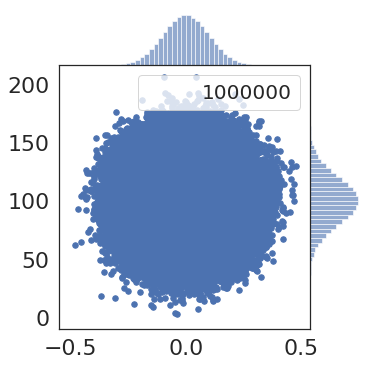

In [5]:
df = pd.DataFrame({"x":x1, "y":x2,"group":np.repeat("original",n)})
plot_stuff(df,"test.png")

#### subsample with cutoff_sig = 0.05, rate = 0.1

Started NN-subsampling, original length: 1000000
use pykdtree backend
Subample with standard scaled data
start total length: 1000000
end cycle. length: 727912	 time:2.3406543731689453
start total length: 727912
end cycle. length: 530949	 time:1.7959046363830566
start total length: 530949
end cycle. length: 387921	 time:1.297847032546997
start total length: 387921
end cycle. length: 284095	 time:0.9735901355743408
start total length: 284095
end cycle. length: 208228	 time:0.6820087432861328
start total length: 208228
end cycle. length: 152692	 time:0.5333895683288574
start total length: 152692
end cycle. length: 112045	 time:0.3928070068359375
start total length: 112045
end cycle. length: 82365	 time:0.28875088691711426
start total length: 82365
end cycle. length: 60614	 time:0.19999098777770996
start total length: 60614
end cycle. length: 44832	 time:0.14884471893310547
start total length: 44832
end cycle. length: 33292	 time:0.10652017593383789
start total length: 33292
end cycle. len

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


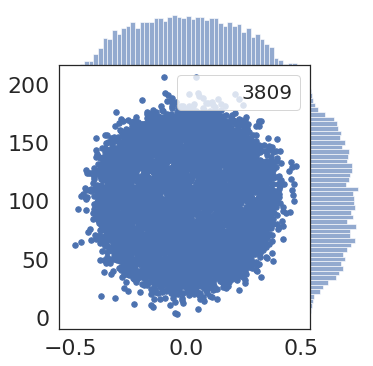

In [6]:
import time
temp = np.column_stack((x1,x2))
start = time.time()
temp_subsampled = np.asarray(subsampling_system(temp,list_desc = [],cutoff_sig=0.05,rate=0.1, method = "pykdtree"))
print("total time: {}".format(time.time()-start))

x_subsampled = temp_subsampled[:,0]
y_subsampled = temp_subsampled[:,1]

df2 = pd.DataFrame({'x':x_subsampled, 'y':y_subsampled, 'group':np.repeat('subsampled',len(x_subsampled))})
df.append(df2)
plot_stuff(df2,"subsampled.png")

### batch subsample test
#### 100000 datapoints in a batch, with 2 levels of batch subsample
subsample with cutoff_sig = 0.05, rate = 0.1


at recursive level 2, length 1000000
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2778	 time:0.8670692443847656
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2717	 time:0.8876357078552246
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2703	 time:0.9135761260986328
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2709	 time:0.8843128681182861
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2732	 time:0.9358222484588623
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2762	 time:0.888826847076416
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 2746	 time:0.8993067741394043
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 27

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


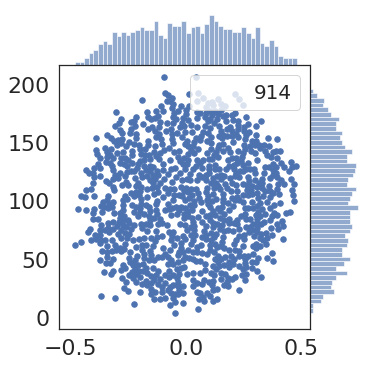

In [7]:
temp = np.column_stack((x1,x2))
start = time.time()
temp_subsampled = np.array(subsampling_system_batch(temp,list_desc = [], batch_size = 100000, recursive_level = 2, \
                                                      cutoff_sig=0.05,rate=0.1, method = "pykdtree",verbose = False))

print("total time: {}".format(time.time()-start))

x_subsampled = temp_subsampled[:,0]
y_subsampled = temp_subsampled[:,1]

df2 = pd.DataFrame({'x':x_subsampled, 'y':y_subsampled, 'group':np.repeat('subsampled',len(x_subsampled))})
df.append(df2)
plot_stuff(df2,"subsampled.png")

### scaling in multiple dimensions with different backend

#### pykdtree backend

In [8]:
temp = np.column_stack((x1,x2))
start = time.time()
subsampling_system(temp,list_desc = [], cutoff_sig=1.0,rate=0.2, method = "pykdtree",verbose = False)

print("2 dimensions, total time: {}\n\n".format(time.time()-start))

temp = np.column_stack((x1,x2,x3,x4,x5))
start = time.time()
subsampling_system(temp,list_desc = [], cutoff_sig=1.0,rate=0.2, method = "pykdtree",verbose = False)

print("5 dimensions,total time: {}\n\n".format(time.time()-start))

temp = np.column_stack((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10))
start = time.time()
subsampling_system(temp,list_desc = [], cutoff_sig=1.0,rate=0.2, method = "pykdtree",verbose = False)

print("10 dimensions total time: {}\n\n".format(time.time()-start))

Started NN-subsampling, original length: 1000000
use pykdtree backend
end subsampling. length: 23	 time:9.745516777038574
2 dimensions, total time: 9.928696393966675


Started NN-subsampling, original length: 1000000
use pykdtree backend
end subsampling. length: 202	 time:20.52124047279358
5 dimensions,total time: 20.6938214302063


Started NN-subsampling, original length: 1000000
use pykdtree backend
end subsampling. length: 1448	 time:409.65187311172485
10 dimensions total time: 409.86517095565796




#### nmslib backend

In [9]:
temp = np.column_stack((x1,x2))
start = time.time()
subsampling_system(temp,list_desc = [], cutoff_sig=1.0,rate=0.2, method = "nmslib",verbose = False)

print("2 dimensions, total time: {}\n\n".format(time.time()-start))

temp = np.column_stack((x1,x2,x3,x4,x5))
start = time.time()
subsampling_system(temp,list_desc = [], cutoff_sig=1.0,rate=0.2, method = "nmslib",verbose = False)

print("5 dimensions,total time: {}\n\n".format(time.time()-start))

temp = np.column_stack((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10))
start = time.time()
subsampling_system(temp,list_desc = [], cutoff_sig=1.0,rate=0.2, method = "nmslib",verbose = False)

print("10 dimensions total time: {}\n\n".format(time.time()-start))

Started NN-subsampling, original length: 1000000
use nmslib backend
end subsampling. length: 23	 time:124.4931309223175
2 dimensions, total time: 124.68793058395386


Started NN-subsampling, original length: 1000000
use nmslib backend
end subsampling. length: 192	 time:230.22288179397583
5 dimensions,total time: 230.37718605995178


Started NN-subsampling, original length: 1000000
use nmslib backend
end subsampling. length: 1432	 time:414.3449261188507
10 dimensions total time: 414.5415346622467




### 10 dimension dataset batch subsample with PCA pre-processing

In [10]:
temp = np.column_stack((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10))

start = time.time()
subsampling_system_with_PCA(temp,list_desc = [], start_trial_component = 5, max_component = 10, target_variance = 0.9999, \
                                  cutoff_sig=1.0,rate=0.2, \
                                  method = "pykdtree",verbose = False)
print("without batch, total time: {}\n\n".format(time.time()-start))

start = time.time()
subsampling_system_with_PCA_batch(temp,list_desc = [], start_trial_component = 5, max_component = 10, target_variance = 0.9999, \
                                  cutoff_sig=1.0,rate=0.2, batch_size = 100000, recursive_level = 2, \
                                  method = "pykdtree",verbose = False)

print("100000 batch size, total time: {}\n\n".format(time.time()-start))

start = time.time()
subsampling_system_with_PCA_batch(temp,list_desc = [], start_trial_component = 5, max_component = 10, target_variance = 0.9999, \
                                  cutoff_sig=1.0,rate=0.2, batch_size = 10000, recursive_level = 2, \
                                  method = "pykdtree",verbose = False)

print("10000 batch size, total time: {}\n\n".format(time.time()-start))

start trial PCA
end trial PCA, number of PC kept: 8 	 took 2.0625030994415283 s
Started NN-subsampling, original length: 1000000
use pykdtree backend
end subsampling. length: 743	 time:155.07873916625977
without batch, total time: 157.3525755405426


at recursive level 2, length 1000000
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.11669683456420898 s
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 412	 time:4.590992450714111
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.09958553314208984 s
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 407	 time:4.473398447036743
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.11528849601745605 s
Started NN-subsampling, original length: 100000
use pykdtree backend
end subsampling. length: 436	 time:4.362966537475586
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.10506176948547363 s
Started NN-subsampling

end subsampling. length: 196	 time:0.3553464412689209
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.025471210479736328 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 203	 time:0.32597923278808594
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.008118152618408203 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 198	 time:0.3328092098236084
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.02502608299255371 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 212	 time:0.3369450569152832
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.017638206481933594 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 217	 time:0.3467550277709961
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.026443958282470703 s
Started NN-subsampling, original length: 10000
u

end subsampling. length: 194	 time:0.34574079513549805
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.029211044311523438 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 183	 time:0.342879056930542
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.01737380027770996 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 194	 time:0.3334474563598633
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.027997970581054688 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 202	 time:0.3325216770172119
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.009344339370727539 s
Started NN-subsampling, original length: 10000
use pykdtree backend
end subsampling. length: 215	 time:0.3423197269439697
start trial PCA
end trial PCA, number of PC kept: 8 	 took 0.019101619720458984 s
Started NN-subsampling, original length: 10000
us

### MNIST dataset test

subsampling with PCA pre-processing and different backend

In [11]:
from mlxtend.data import loadlocal_mnist
from matplotlib import pyplot as plt

X, y = loadlocal_mnist(
        images_path='./train-images-idx3-ubyte', 
        labels_path='./train-labels-idx1-ubyte')


start trial PCA
stopped PCA at 121 components, total explained variance: 0.931847057397987
end trial PCA, number of PC kept: 121 	 took 21.237131118774414 s
Started NN-subsampling, original length: 60000
use nmslib backend
end subsampling. length: 15	 time:48.91304874420166


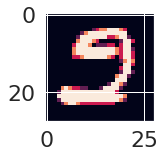

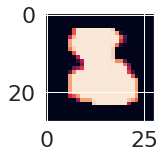

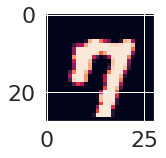

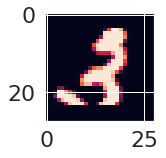

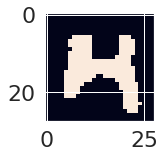

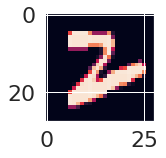

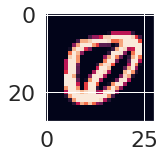

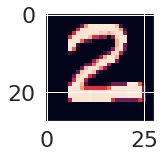

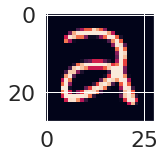

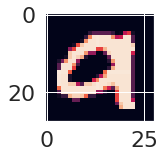

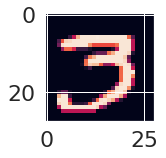

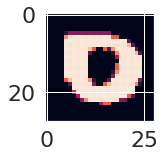

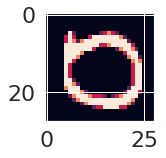

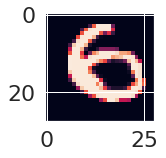

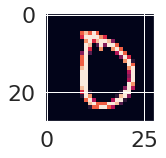

In [12]:
result = subsampling_system_with_PCA(X,list_desc = [],standard_scale = False, max_component = 120, target_variance = 0.98,\
                                     cutoff_sig=1.5,rate=0.1, method = "nmslib", verbose = False)
for image in result:
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape(28,28))
    plt.show()

start trial PCA
stopped PCA at 121 components, total explained variance: 0.9318470573979872
end trial PCA, number of PC kept: 121 	 took 20.964025497436523 s
Started NN-subsampling, original length: 60000
use pykdtree backend
end subsampling. length: 10	 time:781.7758963108063


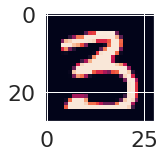

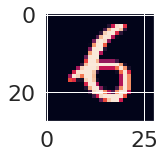

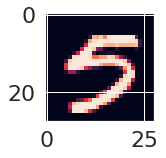

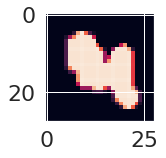

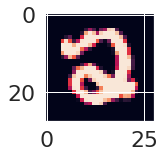

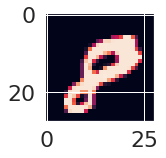

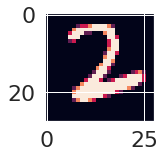

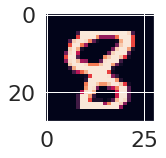

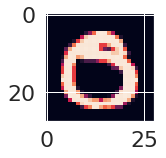

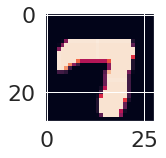

In [13]:
result = subsampling_system_with_PCA(X,list_desc = [],standard_scale = False, max_component = 120, target_variance = 0.98,\
                                     cutoff_sig=1.5,rate=0.1, method = "pykdtree", verbose = False)
for image in result:
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape(28,28))
    plt.show()

start trial PCA
stopped PCA at 121 components, total explained variance: 0.9318470573979862
end trial PCA, number of PC kept: 121 	 took 23.66104817390442 s
Started NN-subsampling, original length: 60000
use annoy backend
end subsampling. length: 13	 time:39.30613875389099


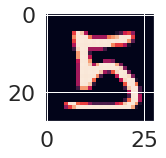

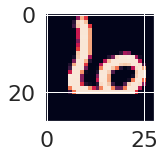

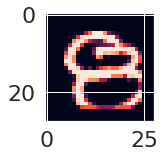

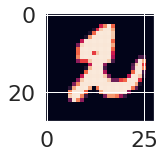

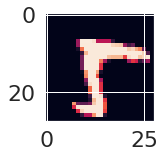

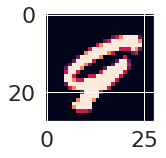

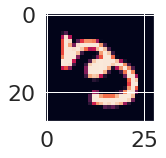

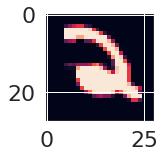

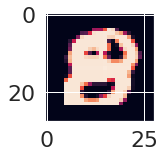

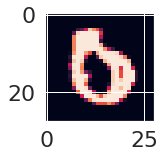

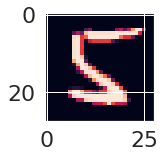

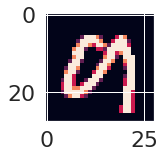

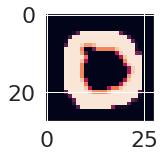

In [14]:
result = subsampling_system_with_PCA(X,list_desc = [],standard_scale = False, max_component = 120, target_variance = 0.98,\
                                     cutoff_sig=1.5,rate=0.1, method = "annoy", verbose = False)
for image in result:
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape(28,28))
    plt.show()

### fashion-MNIST dataset test

subsampling with PCA pre-processing and different backend

In [15]:
X, y = loadlocal_mnist(
        images_path='./train-fasion-images-idx3-ubyte', 
        labels_path='./train-fasion-labels-idx1-ubyte')

start trial PCA
stopped PCA at 121 components, total explained variance: 0.9245309238264565
end trial PCA, number of PC kept: 121 	 took 23.837438821792603 s
Started NN-subsampling, original length: 60000
use nmslib backend
end subsampling. length: 13	 time:47.22124934196472


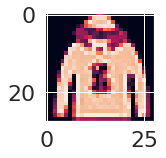

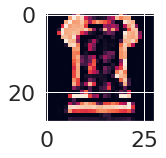

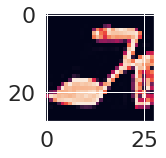

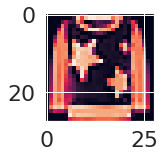

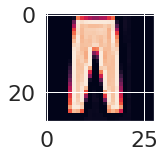

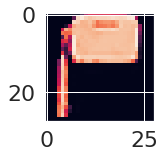

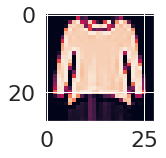

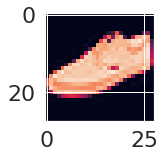

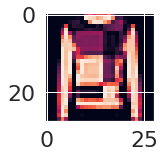

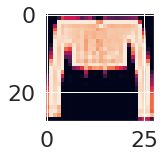

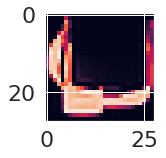

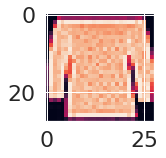

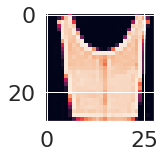

In [16]:
result = subsampling_system_with_PCA(X,list_desc = [],standard_scale = False, max_component = 120, target_variance = 0.98,\
                                     cutoff_sig=1.5,rate=0.1, method = "nmslib", verbose = False)
for image in result:
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape(28,28))
    plt.show()

start trial PCA
stopped PCA at 121 components, total explained variance: 0.9245309238264563
end trial PCA, number of PC kept: 121 	 took 24.026893138885498 s
Started NN-subsampling, original length: 60000
use pykdtree backend
end subsampling. length: 15	 time:249.70541143417358


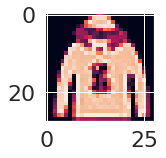

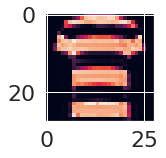

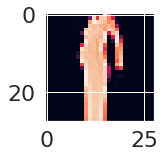

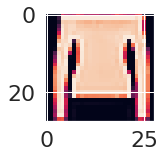

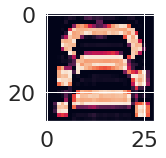

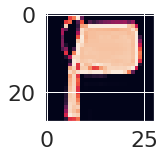

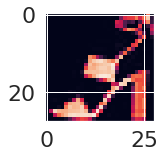

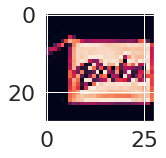

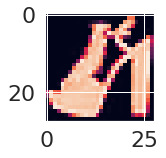

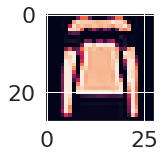

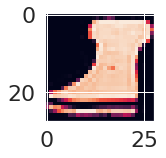

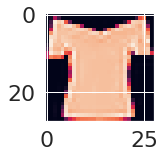

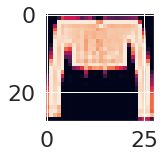

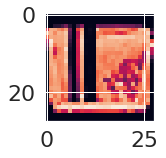

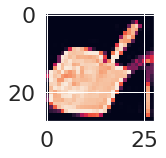

In [17]:
result = subsampling_system_with_PCA(X,list_desc = [],standard_scale = False, max_component = 120, target_variance = 0.98,\
                                     cutoff_sig=1.5,rate=0.1, method = "pykdtree", verbose = False)
for image in result:
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape(28,28))
    plt.show()

start trial PCA
stopped PCA at 121 components, total explained variance: 0.9245309238264563
end trial PCA, number of PC kept: 121 	 took 21.240264177322388 s
Started NN-subsampling, original length: 60000
use annoy backend
end subsampling. length: 12	 time:39.54623198509216


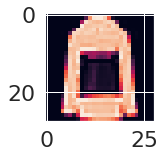

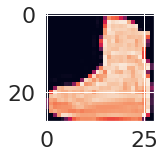

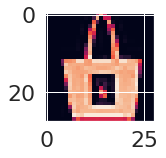

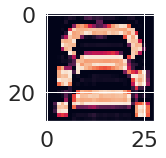

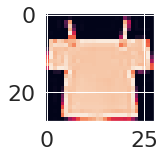

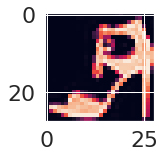

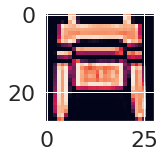

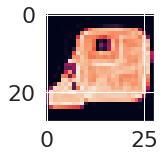

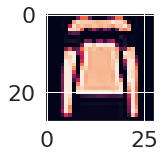

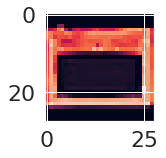

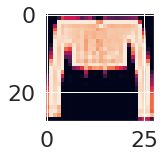

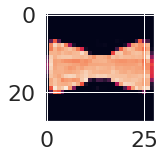

In [18]:
result = subsampling_system_with_PCA(X,list_desc = [],standard_scale = False, max_component = 120, target_variance = 0.98,\
                                     cutoff_sig=1.5,rate=0.1, method = "annoy", verbose = False)
for image in result:
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape(28,28))
    plt.show()